In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 300
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonflyer, a dragonfly in a dragonfly.

The dragonfly in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies in my dreams.

Dragonflies


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>o2<msg>Br "I see. Well, alcoholism and suicide both are huge problems in law enforcement."<|endoftext|><d><scn>o2<msg>An "Interesting. What's in it for me?"<|endoftext|><d><scn>facin2<msg>m "I heard some commotion in the distance, and when I approached, I was surprised to see not only Anna, but Remy as well."<|endoftext|><d><scn>bare<msg>Br "Oh, come on, just try a little. Even if you don't like beer, you
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


 do on a daily basis, it can affect you in pretty bad ways. Everyone has their breaking point."<|endoftext|><p><msg>c "Fight Bryce"<d><scn>o2<msg>m "I didn't hesitate and kicked Bryce right in the stomach"<|endoftext|><d><scn>loremapt<msg>Lo "I thought you had experiments to run."<|endoftext|><p><msg>c "That I am."<|endoftext|><d><scn>park3<msg>Em "The question is: Did Maverick cause this, or did he just fail to prevent it?"<|endoftext|><p
><msg>c "Okay."<p><msg>c "I really should be going now."<d><scn>black<msg>Lo "Take care."<p><msg>c "Yeah, you too."<p><msg>c "Yeah, you too."<|endoftext|><p><msg>c "Err..."<|endoftext|><p><msg>c "I suppose so..."<|endoftext|><p><msg>c "That is unfortunate."<|endoftext|><d><scn>black<msg>Ry "It's not as if I was desperate or anything. I just think it's nice."<|endoftext|><


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
321,1.511300
642,1.338000
963,1.406500
1284,1.413900
1605,1.415600
1926,1.410300
2247,1.412700
2568,1.412100
2889,1.410500
3210,1.413000


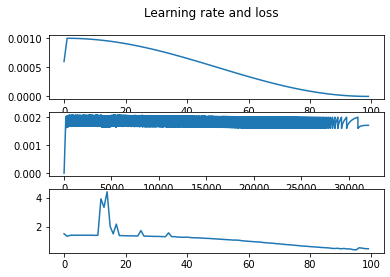

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 1.14 MiB/s, done.
Using framework PyTorch: 1.10.0+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyTor

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon. I eat. I cover myself with sand. I drink. I work. I hope you're doing right about that way."<d><scn2<msg id=" subpoenaseed"<o: \"gp\ signs\n"<|endoftext|>
PyTorch: In my dreams, I'm a dragon. I come for everything from fish to cake. My muscles are very sensitive and my intellect, not very knowledge-bearing."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I eat. I drink to order."<|endoftext|>
PyTorch: In my dreams, I'm a dragon."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I eat. I cover myself with sand. I work in the archives."<|endoftext|>
PyTorch: In my dreams, I'm a dragon."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. I eat. I cover myself with

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon. I live by theijuana, and I suppose that is because theLaughsumey way of my life is so much I ask for it any more."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I'm good. I'll let you have your own people, and once you've got a base ofirlfriends, what, you think I don't know what tojosh."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I'm not sure if there are any better than human my infinite wisdom, and the existence of which has only)}2.}<p><msg>c "What?"<d><scn>park2<msg>Ry "I suppose so."<p><msg>c "What do you think, Iguers?"<d><


Prompt: Oh my god, Adine. What is this?
Reply: np2x<msg>Ad "Well, what does that make you?"<|endoftext|>


Prompt: What will we do here?
Reply: facin2<msg>An "I don't know where you are going, but I think I need a coffee or five. You can tag along if you like."<p><msg>c "I think I'd rather not."<d><scn>facin2<msg>An "I can see that."<p><msg>c "I think I'd rather not."<d><scn>facin2


Test ONNX...
Prompt: How are you?
Reply: park2<msg>Ry "I'm good. I'll let you have your own people, and once you've got a base ofirlfriends, what, y

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Hey [player_name]!"<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I've said this word to myself for ages\�¶I know it, it was realfor me\... It seemedlike forever\... That is, if anyone was waiting for\."<p><msg>c "What did you say?"<d><scn>park2<msg>Ry "I'm not sure I'd

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: np3<msg>Ka "I'm glad you're even."<d><scn>np3<msg>Ka "Of the reptiles, because of course they do."<d><scn>np3<msg>Ka "You asked the fact that you� were here when you came into what's now, I'm supposed to be around."<d><scn>np3<msg>

[Test 1] -> Prompt: What will we do here?
Reply: facin2<msg>An "If anything were to change,I'd have to change my mind."<d><scn>facin2<msg>An "I wouldn't do anything like that."<d><scn>facin2<msg>An "I didn't really want to make a big deal out of it, though, so that might be... a 'You'dp cause of for at least a little

---------

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]!"<|endoftext|>
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
Visit Adine -> adineapt<msg>Ad "I'm not sure if I could do with any higher masculine than the question."<|endoftext|>
Fight Maverick -> emeraroom<msg>Em "I've mentioned this before, so it's no fault some unknown time and means only the attics of wonder receive my vote."<d><scn>emeraroom<msg>Em "Of course I can't keep up this way, and I can tell from a research department's point of view this simple: find a replacement."<d><scn>emeraroom<msg>Em "The truth is, I could never really provide any number of other types of support. The public in
Fight Adine -> cafe<msg>Ad "I'm not sure I've seen you. I probably shouldn't think to ask you all the time."<|endoftext|>
Attack Adine -> emeraroom<msg>m "Adine, you there, and you take me on your ever-present needas."<d><scn>emeraroom<msg>Em "I know it's a strange request, but having to wait and have the pr